# Dive into Deep Learning notebook

Import Python modules

In [24]:
from d2l import torch as d2l

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import ceil, floor

%matplotlib inline

In [2]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

## 8. Recurrent Neural Networks

### 8.1 Sequence Models

Start by generating a 1D time series.

(1.0, 1000.0)

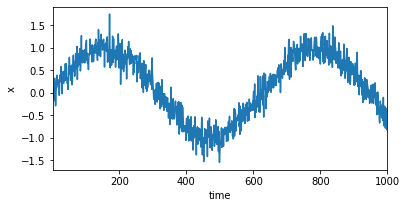

In [3]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(0, figsize=(6, 3))
plt.plot(time, x.numpy())
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, 1000])

Define features and labels.

In [4]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

Create a subclass of "Dataset" to load the data.

In [5]:
class TsDataset(Dataset):
    def __init__(self, features, labels=None):
        self.X = features
        self.y = labels
         
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, i):
        data = self.X[i, :]
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

Model parameters.

In [6]:
batch_size = 16
n_train = 600

Define the training and test sets.

In [7]:
train_data = TsDataset(features[:n_train, :], labels[:n_train])
test_data = TsDataset(features[n_train:, :], labels[n_train:])

Define the dataloaders to iterate over the training set and the test set.

In [8]:
train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=True)

This is a function for initializing the weights of the linear layers of the neural network.

In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

We define a simple multi-layer perceptron.

In [10]:
def get_net(tau):
    net = nn.Sequential(nn.Linear(tau, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

We use the Mean Square Error for the loss.

In [11]:
loss = nn.MSELoss(reduction='none')

Finally, we define a function to train the model.

In [12]:
def train(net, train_iter, test_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        train_loss = 0.0
        test_loss = 0.0
        for X, y in train_iter:
            trainer.zero_grad()
            l_train = loss(net(X), y)
            train_loss = train_loss + l_train.sum()
            l_train.sum().backward()
            trainer.step()
        for X, y in test_iter:
            l_test = loss(net(X), y)
            test_loss = test_loss + l_train.sum()
        print(f'epoch {epoch + 1}', f'train loss {train_loss}', f'test loss {test_loss}')

We train the model and compute the training loss and testing loss.

In [13]:
net = get_net(tau)
train(net, train_iter, test_iter, loss, 5, 0.01)

epoch 1 train loss 56.84735870361328 test loss 17.346603393554688
epoch 2 train loss 32.347965240478516 test loss 7.792640686035156
epoch 3 train loss 30.576313018798828 test loss 2.730132818222046
epoch 4 train loss 29.86651611328125 test loss 3.545186996459961
epoch 5 train loss 29.857175827026367 test loss 5.991896152496338


We visualize one-step-ahead predictions.

In [14]:
onestep_preds = net(features)

(1.0, 1000.0)

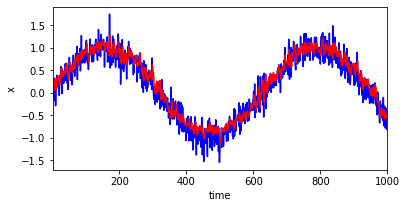

In [15]:
plt.figure(0, figsize=(6, 3))
plt.plot(time, x.detach().numpy(), 'b-', label='Data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), 'r-', label='Predictions')
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, 1000])

We now visualize k-step ahead predictions.

In [16]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

(1.0, 1000.0)

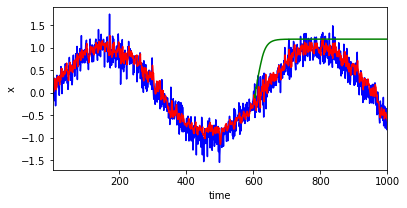

In [17]:
plt.figure(0, figsize=(6, 3))
plt.plot(time, x.detach().numpy(), 'b-', label='Data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), 'r-', label='One-step-ahead')
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy(), 'g-', label='k-step-ahead')
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, 1000])

Let us look at k-step-ahead predictions for k = 1, 4, 16, 64.

In [18]:
max_steps = 64

features_test = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features_test[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features_test[:, i] = net(features_test[:, i - tau:i]).reshape(-1)

(1.0, 1000.0)

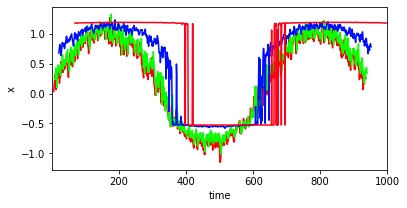

In [19]:
steps = (1, 4, 16, 64)
cmap = get_cmap(len(steps))

plt.figure(0, figsize=(6, 3))
for count, i in enumerate(steps):
    plt.plot(time[tau + i - 1: T - max_steps + i], features_test[:, (tau + i - 1)].detach().numpy(), color=cmap(count), label='{:d}-steps'.format(i))
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, 1000])

## 8.2 Application to Earthquake Data

We transform the earthquake catalog into a time series by counting the number of earthquakes per unit of time.

In [21]:
data = pd.read_csv('../data/Phuket.csv')

In [22]:
times = data['time'].to_numpy()

In [25]:
events = np.zeros(int(ceil(np.max(times))))
for i in range(0, len(times)):
    index = int(floor(times[i]))
    events[index] = events[index] + 1

(1.0, 1826.0)

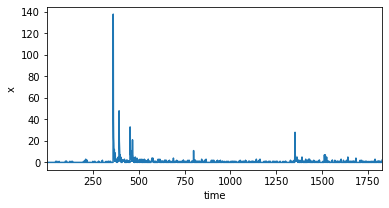

In [26]:
T = len(events)
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.from_numpy(events.astype(np.float32))
plt.figure(0, figsize=(6, 3))
plt.plot(time, x.numpy())
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, T])

We apply to the earthquake dataset the same analysis that was used above on the synthetic time series.

In [27]:
tau = 100
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [28]:
batch_size = 16
n_train = 1200

In [29]:
train_data = TsDataset(features[:n_train, :], labels[:n_train])
test_data = TsDataset(features[n_train:, :], labels[n_train:])

In [30]:
train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [31]:
net = get_net(tau)
train(net, train_iter, test_iter, loss, 5, 0.01)

epoch 1 train loss 41426.51953125 test loss 603.0234985351562
epoch 2 train loss 25644.59375 test loss 960.79052734375
epoch 3 train loss 23120.103515625 test loss 644.7568969726562
epoch 4 train loss 21794.4453125 test loss 139.0307159423828
epoch 5 train loss 21470.689453125 test loss 143.0121307373047


In [32]:
onestep_preds = net(features)

(1.0, 1826.0)

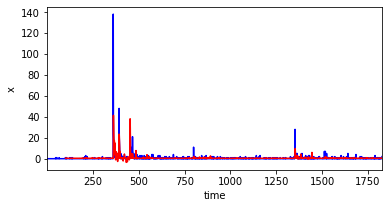

In [37]:
plt.figure(0, figsize=(6, 3))
plt.plot(time, x.detach().numpy(), 'b-', label='Data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), 'r-', label='Predictions')
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, T])

In [34]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

(1.0, 1826.0)

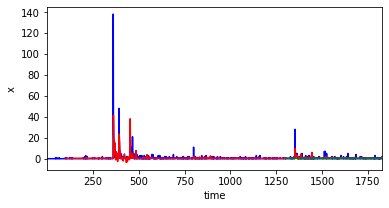

In [38]:
plt.figure(0, figsize=(6, 3))
plt.plot(time, x.detach().numpy(), 'b-', label='Data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), 'r-', label='One-step-ahead')
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy(), 'g-', label='k-step-ahead')
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, T])

In [36]:
max_steps = 64

features_test = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features_test[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features_test[:, i] = net(features_test[:, i - tau:i]).reshape(-1)

(1.0, 1826.0)

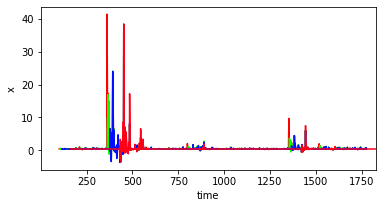

In [39]:
steps = (1, 4, 16, 64)
cmap = get_cmap(len(steps))

plt.figure(0, figsize=(6, 3))
for count, i in enumerate(steps):
    plt.plot(time[tau + i - 1: T - max_steps + i], features_test[:, (tau + i - 1)].detach().numpy(), color=cmap(count), label='{:d}-steps'.format(i))
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, T])

## 8.3 Encoding the Earthquake Time Series

We now also read the magnitudes of the earthquakes.

In [78]:
data = pd.read_csv('../data/Phuket.csv')

In [80]:
times = data['time'].to_numpy()
magnitudes = data['mb'].to_numpy()

In [81]:
T = int(ceil(np.max(times)))
tau = 100

In [89]:
m = np.linspace(np.min(magnitudes), np.max(magnitudes), int(10 * (np.max(magnitudes) - np.min(magnitudes))) + 1)

In [92]:
features = torch.zeros((T - tau - 1, tau, len(m)))
labels = torch.zeros((T - tau - 1, len(m)))
for i in range(0, T - tau - 1):
    for j in range(0, len(times)):
        index_t = int(floor(times[j] - i))
        index_m = int(10 * (magnitudes[j] - np.min(magnitudes)))
        if ((index_t >= 0) and (index_t < tau)):
            features[i, index_t, index_m] = features[i, index_t, index_m] + 1
        if index_t == tau:
            labels[i, index_m] = labels[i, index_m] + 1

Create a subclass of "Dataset" to load the data.

In [109]:
class EqDataset(Dataset):
    def __init__(self, features, labels=None):
        self.X = features
        self.y = labels
         
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, i):
        data = self.X[i, :, :]
        if self.y is not None:
            return (data, self.y[i, :])
        else:
            return data

Model parameters.

In [110]:
batch_size = 16
n_train = 1200

Define the training and test sets.

In [111]:
train_data = EqDataset(features[:n_train, :, :], labels[:n_train, :])
test_data = EqDataset(features[n_train:, :, :], labels[n_train:, :])

Define the dataloaders to iterate over the training set and the test set.

In [112]:
train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## 8.5 Implementation of Recurrent Neural Networks from Scratch

Initialization of model parameters.

In [117]:
def get_params(magn_size, num_hiddens):
    num_inputs = num_outputs = magn_size

    def normal(shape):
        return torch.randn(size=shape) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

Initialization of the hidden state.

In [118]:
def init_rnn_state(batch_size, num_hiddens):
    return (torch.zeros((batch_size, num_hiddens)), )

Define the RNN layer.

In [119]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `magn_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `magn_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

Define the network.

In [122]:
class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, magn_size, num_hiddens, get_params, init_state, forward_fn):
        self.magn_size, self.num_hiddens = magn_size, num_hiddens
        self.params = get_params(magn_size, num_hiddens)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

Let us check the dimensions of the outputs.

In [124]:
num_hiddens = 512
net = RNNModelScratch(len(m), num_hiddens, get_params, init_rnn_state, rnn)
state = net.begin_state(features[0, :, :].shape[0])
Y, new_state = net(features[0, :, :], state)
Y.shape, len(new_state), new_state[0].shape

RuntimeError: self must be a matrix